In [1]:
from generate_paths import get_all_files
import six.moves.cPickle as pickle
import numpy as np
import copy
from joblib import Parallel, delayed

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import prettyplotlib as ppl
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [4]:
features = []
with open('features_inc.pkl', 'rb') as pickle_file:
    try:
       for _ in range(500000):
            entry = pickle.load(pickle_file, encoding='bytes', fix_imports=True)
            features.append(entry)
    except EOFError:
        pass

In [5]:
feat_list = ['key','mode','loudness','danceability','duration','energy','mode']

In [6]:
data = map(lambda x: x[1], features)
data = list(filter(lambda x: 'year' in x and x['year']>=1965, data))

In [7]:
len(data)

208399

In [8]:
granularity = 5
labels = list(map(lambda x: x['year'], data))
labels -= min(labels)
labels = np.array(list(map(int, labels)))
classes = list(map(lambda x: x//granularity, labels))

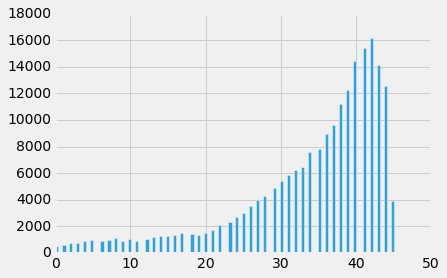

In [9]:
plt.hist(labels, 100);

In [10]:
BASELINE = 33.95
np.mean((labels-BASELINE)**2)

In [12]:
X = np.array([[entry[feat] for feat in feat_list] for entry in data])

In [13]:
regressors = [#LinearRegression(),
              Ridge(alpha = 1.0),
             ]
classifiers = [AdaBoostClassifier(),
               RidgeClassifier(tol=1e-2, solver="lsqr"),
               #Perceptron(n_iter=50),
               #PassiveAggressiveClassifier(n_iter=50),
               #KNeighborsClassifier(n_neighbors=10),
               #RandomForestClassifier(),
               RandomForestClassifier(n_estimators=200, criterion = 'entropy'),
               LinearSVC(loss='l2', penalty='l2', dual=False, tol=1e-3),
               #MultinomialNB(alpha=0.1),
               #BernoulliNB(alpha=0.1),
               SGDClassifier(alpha=.0001, n_iter=200, penalty='l2'),
               SVC()
              ]

In [14]:
for clf in regressors:
    scores = -cross_val_score(clf, X, labels, cv=5, scoring='neg_mean_squared_error')
    print(clf.__class__.__name__, 'Mean Square Deviations', scores)

Ridge Mean Square Deviations [ 88.18264686  89.06013022  88.81315605  88.23036128  90.05891798]


In [ ]:
predictions = Parallel(n_jobs=-1)(
    delayed(cross_val_predict)(clf, X, classes, cv=5)
    for clf in classifiers)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will 

In [ ]:
tmp = list(zip(map(lambda x: x.__class__.__name__,classifiers), [metrics.accuracy_score(classes, predicted) for predicted in predictions]))
print(*tmp, sep='\n')